In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import KMeans
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, confusion_matrix,
                              accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
                              silhouette_score, calinski_harabasz_score, davies_bouldin_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph


torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f'Importing Data_preprocess_3Omics processed datasets for direct fusion analysis')
print("=" * 80)

# Load the preprocessed datasets from Data_preprocess_3Omics pipeline
print("🔄 Loading preprocessed datasets...")
expression_scaled2 = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0)
methylation_scaled2 = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0)
copy_number_scaled2 = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0)
phenotype_data_clean2 = pd.read_csv("../NewDatasets/processed_phenotype_FXS_OG.csv", index_col=0)
labels = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

print("📊 Original Dataset Shapes (Features x Samples):")
print(f"   Expression: {expression_scaled2.shape} (genes x samples)")
print(f"   Methylation: {methylation_scaled2.shape} (CpG sites x samples)")
print(f"   Copy Number: {copy_number_scaled2.shape} (regions x samples)")
print(f"   Phenotype: {phenotype_data_clean2.shape} (samples x features)")
print(f"   Labels: {labels.shape} (samples)")

# Transpose omics data to have samples as rows (required for ML models)
print("\n🔄 Transposing omics data (samples as rows)...")
expression_scaled2 = expression_scaled2.T  # Now (samples x genes)
methylation_scaled2 = methylation_scaled2.T  # Now (samples x CpG sites)
copy_number_scaled2 = copy_number_scaled2.T  # Now (samples x regions)

# Apply variance threshold (0.1) before StandardScaler
vt = VarianceThreshold(threshold=0.1)
expression_scaled2 = pd.DataFrame(
    vt.fit_transform(expression_scaled2),
    index=expression_scaled2.index,
    columns=expression_scaled2.columns[vt.get_support()]
)
vt = VarianceThreshold(threshold=0.1)
methylation_scaled2 = pd.DataFrame(
    vt.fit_transform(methylation_scaled2),
    index=methylation_scaled2.index,
    columns=methylation_scaled2.columns[vt.get_support()]
)
vt = VarianceThreshold(threshold=0.1)
copy_number_scaled2 = pd.DataFrame(
    vt.fit_transform(copy_number_scaled2),
    index=copy_number_scaled2.index,
    columns=copy_number_scaled2.columns[vt.get_support()]
)

expression_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(expression_scaled2),
    index=expression_scaled2.index,
    columns=expression_scaled2.columns
)

methylation_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(methylation_scaled2),
    index=methylation_scaled2.index,
    columns=methylation_scaled2.columns
)

copy_number_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(copy_number_scaled2),
    index=copy_number_scaled2.index,
    columns=copy_number_scaled2.columns
)

print("\n✅ Omics data standardized (samples as rows, features scaled column-wise).")
# print("Expression data (final scaled shape):", expression_scaled_final.shape)

print("📊 After transpose (Samples x Features):")
print(f"   Expression: {expression_scaled2.shape} (samples x genes)")
print(f"   Methylation: {methylation_scaled2.shape} (samples x CpG sites)")
print(f"   Copy Number: {copy_number_scaled2.shape} (samples x regions)")

# Verify data quality (should have no missing values from preprocessing)
print("\n🔍 Data Quality Check:")
print(f"   Expression missing values: {expression_scaled2.isnull().sum().sum()}")
print(f"   Methylation missing values: {methylation_scaled2.isnull().sum().sum()}")
print(f"   Copy Number missing values: {copy_number_scaled2.isnull().sum().sum()}")
print(f"   Labels missing values: {labels.isnull().sum().sum()}")

# Check sample alignment (should be perfect from preprocessing)
common_samples_check = [
    set(expression_scaled2.index),
    set(methylation_scaled2.index), 
    set(copy_number_scaled2.index),
    set(labels.index)
]

all_aligned = all(s == common_samples_check[0] for s in common_samples_check)
print(f"\n✅ Sample alignment: {'Perfect' if all_aligned else 'Misaligned'}")
print(f"📊 Total samples: {len(expression_scaled2)}")


Importing Data_preprocess_3Omics processed datasets for direct fusion analysis
🔄 Loading preprocessed datasets...
📊 Original Dataset Shapes (Features x Samples):
   Expression: (44663, 205) (genes x samples)
   Methylation: (419542, 205) (CpG sites x samples)
   Copy Number: (56756, 205) (regions x samples)
   Phenotype: (205, 78) (samples x features)
   Labels: (205, 1) (samples)

🔄 Transposing omics data (samples as rows)...
📊 Original Dataset Shapes (Features x Samples):
   Expression: (44663, 205) (genes x samples)
   Methylation: (419542, 205) (CpG sites x samples)
   Copy Number: (56756, 205) (regions x samples)
   Phenotype: (205, 78) (samples x features)
   Labels: (205, 1) (samples)

🔄 Transposing omics data (samples as rows)...

✅ Omics data standardized (samples as rows, features scaled column-wise).
📊 After transpose (Samples x Features):
   Expression: (205, 18608) (samples x genes)
   Methylation: (205, 388929) (samples x CpG sites)
   Copy Number: (205, 56756) (samples x

In [3]:
# Apply PCA to Individual Omics First, Then Create Fusion
print("Applying PCA to Individual Omics, Then Creating Fusion...")
print("=" * 80)

# PCA components for each omic type
pca_components = {
    'expression': 50,
    'methylation': 120, 
    'cnv': 70
}

pca_expression = PCA(n_components=pca_components['expression'], random_state=42)
expression_pca = pd.DataFrame(
    pca_expression.fit_transform(expression_scaled2),
    index=expression_scaled2.index,
    columns=[f'Expr_PC{i+1}' for i in range(pca_components['expression'])]
)

pca_methylation = PCA(n_components=pca_components['methylation'], random_state=42)
methylation_pca = pd.DataFrame(
    pca_methylation.fit_transform(methylation_scaled2),
    index=methylation_scaled2.index,
    columns=[f'Meth_PC{i+1}' for i in range(pca_components['methylation'])]
)

pca_cnv = PCA(n_components=pca_components['cnv'], random_state=42)
cnv_pca = pd.DataFrame(
    pca_cnv.fit_transform(copy_number_scaled2),
    index=copy_number_scaled2.index,
    columns=[f'CNV_PC{i+1}' for i in range(pca_components['cnv'])]
)

print(f"\n🔗 Creating Fusion from Individual PCA Results...")
fpca_individual_fusion = pd.concat([
    expression_pca,
    methylation_pca, 
    cnv_pca
], axis=1)

# Verify no missing values
print(f"\n🔍 Data Quality Check:")
print(f"   Individual PCA fusion missing values: {fpca_individual_fusion.isnull().sum().sum()}")

Applying PCA to Individual Omics, Then Creating Fusion...

🔗 Creating Fusion from Individual PCA Results...

🔍 Data Quality Check:
   Individual PCA fusion missing values: 0

🔗 Creating Fusion from Individual PCA Results...

🔍 Data Quality Check:
   Individual PCA fusion missing values: 0


# MLP-Based Analysis Pipeline

This section implements MLP-based feature extraction followed by machine learning classification.

In [4]:
# MLP Feature Extractor Class and Training Function
print("MLP ARCHITECTURE DEFINITION")
print("=" * 80)

class MLP(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(MLP, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        return self.feature_extractor(x)

class ShallowMLP(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(ShallowMLP, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.feature_extractor(x)

def train_mlp(model, data, device, epochs=400, lr=0.001, patience=15, normalize=True):
    # Optionally normalize features to mean=0, std=1
    if normalize:
        scaler = StandardScaler()
        data_np = scaler.fit_transform(data.cpu().numpy() if torch.is_tensor(data) else data)
    else:
        data_np = data.cpu().numpy() if torch.is_tensor(data) else data

    # Split into train/val
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # For unsupervised feature learning, we use a simple contrastive approach
    # We create positive pairs by adding small noise and negative pairs from different samples
    def create_pairs(X, noise_std=0.1):
        # Positive pairs: original + noisy version
        noise = torch.randn_like(X) * noise_std
        X_pos = X + noise
        
        # Negative pairs: random shuffle
        idx = torch.randperm(X.size(0))
        X_neg = X[idx]
        
        return X_pos, X_neg

    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        
        # Create positive and negative pairs
        X_pos, X_neg = create_pairs(X_train_tensor)
        
        # Get embeddings
        z_orig = model(X_train_tensor)
        z_pos = model(X_pos)
        z_neg = model(X_neg)
        
        # Contrastive loss: pull positive pairs together, push negative pairs apart
        pos_loss = torch.mean((z_orig - z_pos) ** 2)
        neg_loss = torch.mean(torch.clamp(1.0 - torch.norm(z_orig - z_neg, dim=1), min=0) ** 2)
        loss = pos_loss + 0.1 * neg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation - use same approach
        model.eval()
        with torch.no_grad():
            X_val_pos, X_val_neg = create_pairs(X_val_tensor)
            z_val_orig = model(X_val_tensor)
            z_val_pos = model(X_val_pos)
            z_val_neg = model(X_val_neg)
            
            val_pos_loss = torch.mean((z_val_orig - z_val_pos) ** 2)
            val_neg_loss = torch.mean(torch.clamp(1.0 - torch.norm(z_val_orig - z_val_neg, dim=1), min=0) ** 2)
            val_loss = val_pos_loss + 0.1 * val_neg_loss

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"   Early stopping at epoch {epoch+1}")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, {'train_losses': train_losses, 'val_losses': val_losses}

print("✅ MLP classes and training function defined!")
print(f"   Deep Architecture: Input → 512 → 256 → Latent (2 layers)")
print(f"   Shallow Architecture: Input → Latent (1 layer)")
print(f"   Features: BatchNorm, Dropout regularization, early stopping, contrastive loss")

MLP ARCHITECTURE DEFINITION
✅ MLP classes and training function defined!
   Deep Architecture: Input → 512 → 256 → Latent (2 layers)
   Shallow Architecture: Input → Latent (1 layer)
   Features: BatchNorm, Dropout regularization, early stopping, contrastive loss


In [5]:
# ML Models Evaluation Function
print("MACHINE LEARNING MODELS DEFINITION")
print("=" * 80)

def evaluate_ml_models_on_embeddings(embeddings, labels, k_folds=5):
    """
    Evaluate multiple ML classifiers on MLP embeddings
    
    Args:
        embeddings: Latent representations from MLP
        labels: Target labels
        k_folds: Number of cross-validation folds
        
    Returns:
        Dictionary with comprehensive metrics for each model
    """
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
        'SVM_RBF': SVC(kernel='rbf', random_state=42, probability=True),
        'KNN': KNeighborsClassifier(n_neighbors=4),
        'NaiveBayes': GaussianNB()
    }
    
    results = {}
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Split data into train and test sets for proper evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    for model_name, model in models.items():
        print(f"\n⚙️  Training {model_name}...")
        
        # Cross-validation scores (on full data for comparison)
        cv_scores = cross_val_score(model, embeddings, labels, cv=skf, scoring='accuracy')
        
        # Train on train set and evaluate on test set (PROPER EVALUATION)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        # Calculate comprehensive metrics on TEST SET
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        
        # AUC (one-vs-rest for multiclass)
        try:
            n_classes = len(np.unique(y_test))
            if n_classes == 2:
                auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            else:
                y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
                auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
        except:
            auc = None
        
        # C-index (concordance index)
        try:
            c_index = concordance_index(y_test, y_pred_proba.max(axis=1))
        except:
            c_index = None
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        results[model_name] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'precision': precision,
            'recall': recall,
            'auc': auc,
            'c_index': c_index,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'confusion_matrix': cm
        }
        
        print(f"   ✅ {model_name}: Accuracy={accuracy:.4f}, F1_macro={f1_macro:.4f}, F1_micro={f1_micro:.4f}")
    
    return results

print("✅ ML evaluation function defined!")
print(f"   Models: RandomForest, GradientBoosting, LogisticRegression, SVM, KNN, NaiveBayes")
print(f"   Metrics: accuracy, f1_macro, f1_micro, precision, recall, AUC, c-index, CV scores")

MACHINE LEARNING MODELS DEFINITION
✅ ML evaluation function defined!
   Models: RandomForest, GradientBoosting, LogisticRegression, SVM, KNN, NaiveBayes
   Metrics: accuracy, f1_macro, f1_micro, precision, recall, AUC, c-index, CV scores


In [6]:
# Execute MLP Pipeline and Store Results
print("MLP PIPELINE EXECUTION")
print("=" * 80)

# Initialize results dictionaries
mlp_scores = {}  # Deep MLP results
shallow_mlp_scores = {}  # Shallow MLP results
mlp_embeddings = {}  # Store embeddings for visualization
shallow_mlp_embeddings = {}  # Store shallow embeddings for visualization

# Latent dimensions to test
latent_dims = [64, 128]

# Device setup
print(f"🖥️  Using device: {device}\n")

# Use the single fusion data
fusion_data = fpca_individual_fusion.values
print(f"🔬 Processing Individual PCA Fusion: {fusion_data.shape}")
print("=" * 80)

# Prepare data once
X = fusion_data
y = labels.values.ravel()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled).to(device)

for latent_dim in latent_dims:
    print(f"\n📊 Latent Dimension: {latent_dim}")
    print("=" * 80)
    
    # ============================================================================
    # DEEP MLP
    # ============================================================================
    print(f"🧠 Training Deep MLP (latent_dim={latent_dim})...")
    mlp_model = MLP(input_dim=X_scaled.shape[1], latent_dim=latent_dim).to(device)
    mlp_model, history = train_mlp(mlp_model, X_tensor, device, epochs=100, patience=15)
    
    # Extract deep MLP latent embeddings
    mlp_model.eval()
    with torch.no_grad():
        embeddings_deep = mlp_model(X_tensor)
        embeddings_deep_np = embeddings_deep.cpu().numpy()
    
    print(f"   ✅ Deep MLP Embeddings shape: {embeddings_deep_np.shape}")
    
    # Evaluate ML models on deep MLP embeddings
    print(f"\n🤖 Evaluating ML Models on Deep MLP Embeddings...")
    ml_results_deep = evaluate_ml_models_on_embeddings(embeddings_deep_np, y, k_folds=5)
    
    # Calculate clustering metrics for deep MLP
    print(f"\n📈 Computing Deep MLP Clustering Metrics...")
    n_clusters = len(np.unique(y))
    kmeans_deep = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_deep = kmeans_deep.fit_predict(embeddings_deep_np)
    
    ari_deep = adjusted_rand_score(y, cluster_labels_deep)
    nmi_deep = normalized_mutual_info_score(y, cluster_labels_deep)
    silhouette_deep = silhouette_score(embeddings_deep_np, cluster_labels_deep)
    calinski_deep = calinski_harabasz_score(embeddings_deep_np, cluster_labels_deep)
    davies_deep = davies_bouldin_score(embeddings_deep_np, cluster_labels_deep)
    
    print(f"   Deep MLP - ARI: {ari_deep:.4f} | NMI: {nmi_deep:.4f} | Silhouette: {silhouette_deep:.4f}")
    print(f"   Deep MLP - Calinski-Harabasz: {calinski_deep:.2f} | Davies-Bouldin: {davies_deep:.4f}")
    
    # Deep MLP contrastive loss (as quality metric)
    mlp_model.eval()
    with torch.no_grad():
        # Create pairs for loss calculation
        noise = torch.randn_like(X_tensor) * 0.1
        X_pos = X_tensor + noise
        idx = torch.randperm(X_tensor.size(0))
        X_neg = X_tensor[idx]
        
        z_orig = mlp_model(X_tensor)
        z_pos = mlp_model(X_pos)
        z_neg = mlp_model(X_neg)
        
        pos_loss = torch.mean((z_orig - z_pos) ** 2)
        neg_loss = torch.mean(torch.clamp(1.0 - torch.norm(z_orig - z_neg, dim=1), min=0) ** 2)
        contrastive_loss = pos_loss + 0.1 * neg_loss
        contrastive_loss_value = contrastive_loss.item()
    
    # Store deep MLP results
    mlp_scores[latent_dim] = {
        'latent_dim': latent_dim,
        'ml_models': ml_results_deep,
        'ari': ari_deep,
        'nmi': nmi_deep,
        'silhouette': silhouette_deep,
        'calinski_harabasz': calinski_deep,
        'davies_bouldin': davies_deep,
        'contrastive_loss': contrastive_loss_value,
        'embeddings_shape': embeddings_deep_np.shape,
        'train_history': history
    }
    
    # Store deep MLP embeddings for visualization
    mlp_embeddings[latent_dim] = embeddings_deep_np
    
    print(f"\n✅ Deep MLP results saved for latent dimension {latent_dim}")
    
    # ============================================================================
    # SHALLOW MLP
    # ============================================================================
    print(f"\n🧠 Training Shallow MLP (latent_dim={latent_dim})...")
    shallow_mlp_model = ShallowMLP(input_dim=X_scaled.shape[1], latent_dim=latent_dim).to(device)
    shallow_mlp_model, shallow_history = train_mlp(shallow_mlp_model, X_tensor, device, epochs=100, patience=15)
    
    # Extract shallow MLP latent embeddings
    shallow_mlp_model.eval()
    with torch.no_grad():
        embeddings_shallow = shallow_mlp_model(X_tensor)
        embeddings_shallow_np = embeddings_shallow.cpu().numpy()
    
    print(f"   ✅ Shallow MLP Embeddings shape: {embeddings_shallow_np.shape}")
    
    # Evaluate ML models on shallow MLP embeddings
    print(f"\n🤖 Evaluating ML Models on Shallow MLP Embeddings...")
    ml_results_shallow = evaluate_ml_models_on_embeddings(embeddings_shallow_np, y, k_folds=5)
    
    # Calculate clustering metrics for shallow MLP
    print(f"\n📈 Computing Shallow MLP Clustering Metrics...")
    kmeans_shallow = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_shallow = kmeans_shallow.fit_predict(embeddings_shallow_np)
    
    ari_shallow = adjusted_rand_score(y, cluster_labels_shallow)
    nmi_shallow = normalized_mutual_info_score(y, cluster_labels_shallow)
    silhouette_shallow = silhouette_score(embeddings_shallow_np, cluster_labels_shallow)
    calinski_shallow = calinski_harabasz_score(embeddings_shallow_np, cluster_labels_shallow)
    davies_shallow = davies_bouldin_score(embeddings_shallow_np, cluster_labels_shallow)
    
    print(f"   Shallow MLP - ARI: {ari_shallow:.4f} | NMI: {nmi_shallow:.4f} | Silhouette: {silhouette_shallow:.4f}")
    print(f"   Shallow MLP - Calinski-Harabasz: {calinski_shallow:.2f} | Davies-Bouldin: {davies_shallow:.4f}")
    
    # Shallow MLP contrastive loss (as quality metric)
    shallow_mlp_model.eval()
    with torch.no_grad():
        # Create pairs for loss calculation
        noise = torch.randn_like(X_tensor) * 0.1
        X_pos = X_tensor + noise
        idx = torch.randperm(X_tensor.size(0))
        X_neg = X_tensor[idx]
        
        z_orig = shallow_mlp_model(X_tensor)
        z_pos = shallow_mlp_model(X_pos)
        z_neg = shallow_mlp_model(X_neg)
        
        pos_loss = torch.mean((z_orig - z_pos) ** 2)
        neg_loss = torch.mean(torch.clamp(1.0 - torch.norm(z_orig - z_neg, dim=1), min=0) ** 2)
        contrastive_loss = pos_loss + 0.1 * neg_loss
        contrastive_loss_shallow = contrastive_loss.item()
    
    # Store shallow MLP results
    shallow_mlp_scores[latent_dim] = {
        'latent_dim': latent_dim,
        'ml_models': ml_results_shallow,
        'ari': ari_shallow,
        'nmi': nmi_shallow,
        'silhouette': silhouette_shallow,
        'calinski_harabasz': calinski_shallow,
        'davies_bouldin': davies_shallow,
        'contrastive_loss': contrastive_loss_shallow,
        'embeddings_shape': embeddings_shallow_np.shape,
        'train_history': shallow_history
    }
    
    # Store shallow MLP embeddings for visualization
    shallow_mlp_embeddings[latent_dim] = embeddings_shallow_np
    
    print(f"\n✅ Shallow MLP results saved for latent dimension {latent_dim}")

print(f"\n{'='*80}")
print(f"🎉 MLP PIPELINES COMPLETED!")
print(f"{'='*80}")
print(f"Deep MLP latent dimensions evaluated: {list(mlp_scores.keys())}")
print(f"Shallow MLP latent dimensions evaluated: {list(shallow_mlp_scores.keys())}")
print(f"Results stored in 'mlp_scores' and 'shallow_mlp_scores' dictionaries")

MLP PIPELINE EXECUTION
🖥️  Using device: cuda

🔬 Processing Individual PCA Fusion: (205, 240)

📊 Latent Dimension: 64
🧠 Training Deep MLP (latent_dim=64)...
   Early stopping at epoch 19
   ✅ Deep MLP Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Deep MLP Embeddings...

⚙️  Training RandomForest...
   Early stopping at epoch 19
   ✅ Deep MLP Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Deep MLP Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.5122, F1_macro=0.2363, F1_micro=0.5122

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.4878, F1_macro=0.2945, F1_micro=0.4878

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.5366, F1_macro=0.3287, F1_micro=0.5366

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5122, F1_macro=0.2381, F1_micro=0.5122

⚙️  Training KNN...
   ✅ GradientBoosting: Accuracy=0.4878, F1_macro=0.2945, F1_micro=0.4878

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.5366, F1_macro=0.3287, F1_micro=0.5366

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5122, F1_macro=0.2381, F1_micro=0.5122

⚙️  Training KNN...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ✅ KNN: Accuracy=0.4634, F1_macro=0.3249, F1_micro=0.4634

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.3902, F1_macro=0.2355, F1_micro=0.3902

📈 Computing Deep MLP Clustering Metrics...
   Deep MLP - ARI: -0.0012 | NMI: 0.0128 | Silhouette: 0.0351
   Deep MLP - Calinski-Harabasz: 6.49 | Davies-Bouldin: 4.0568

✅ Deep MLP results saved for latent dimension 64

🧠 Training Shallow MLP (latent_dim=64)...
   Early stopping at epoch 19
   ✅ Shallow MLP Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Shallow MLP Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.4390, F1_macro=0.1579, F1_micro=0.4390

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.3415, F1_macro=0.1648, F1_micro=0.3415

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.4878, F1_macro=0.3230, F1_micro=0.4878

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5366, F1_macro=0.2886, F1_micro=0.5366

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.4634, F1_macro=0.2848, F1_micro=0.4634

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.3415, F1_macro=0.2396, F1_micro=0.3415

📈 Computing Shallow MLP Clustering Metrics...
   ✅ GradientBoosting: Accuracy=0.3415, F1_macro=0.1648, F1_micro=0.3415

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.4878, F1_macro=0.3230, F1_micro=0.4878

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5366, F1_macro=0.2886, F1_micro=0.5366

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.4634, F1_macro=0.2848, F1_micro=0.4634

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Ac

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   Shallow MLP - ARI: -0.0138 | NMI: 0.0220 | Silhouette: 0.0217
   Shallow MLP - Calinski-Harabasz: 4.42 | Davies-Bouldin: 4.6699

✅ Shallow MLP results saved for latent dimension 64

📊 Latent Dimension: 128
🧠 Training Deep MLP (latent_dim=128)...
   Early stopping at epoch 17
   ✅ Deep MLP Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Deep MLP Embeddings...

⚙️  Training RandomForest...
   Early stopping at epoch 17
   ✅ Deep MLP Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Deep MLP Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.4634, F1_macro=0.2364, F1_micro=0.4634

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.3659, F1_macro=0.2094, F1_micro=0.3659

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.3902, F1_macro=0.2309, F1_micro=0.3902

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5122, F1_macro=0.2607, F1_micro=0.5122

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.4146, F1_macro=0.2682, F1_micro=0.4146

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.2439, F1_macro=0.1585, F1_micro=0.2439

📈 Computing Deep MLP Clustering Metrics...
   ✅ GradientBoosting: Accuracy=0.3659, F1_macro=0.2094, F1_micro=0.3659

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.3902, F1_macro=0.2309, F1_micro=0.3902

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5122, F1_macro=0.2607, F1_micro=0.5122

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.4146, F1_macro=0.2682, F1_micro=0.4146

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accur

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   Deep MLP - ARI: 0.0252 | NMI: 0.0408 | Silhouette: 0.0141
   Deep MLP - Calinski-Harabasz: 6.38 | Davies-Bouldin: 4.4611

✅ Deep MLP results saved for latent dimension 128

🧠 Training Shallow MLP (latent_dim=128)...
   Early stopping at epoch 16
   ✅ Shallow MLP Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Shallow MLP Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.5854, F1_macro=0.3290, F1_micro=0.5854

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.5610, F1_macro=0.3797, F1_micro=0.5610

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.4634, F1_macro=0.3539, F1_micro=0.4634

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5854, F1_macro=0.3290, F1_micro=0.5854

⚙️  Training KNN...
   ✅ GradientBoosting: Accuracy=0.5610, F1_macro=0.3797, F1_micro=0.5610

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.4634, F1_macro=0.3539, F1_micro=0.4634

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5854, F1_macro=0.3290, F1_micro=0.5854

⚙️  Training KNN...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ✅ KNN: Accuracy=0.3415, F1_macro=0.1886, F1_micro=0.3415

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.4634, F1_macro=0.4043, F1_micro=0.4634

📈 Computing Shallow MLP Clustering Metrics...
   Shallow MLP - ARI: 0.0128 | NMI: 0.0326 | Silhouette: -0.0095
   Shallow MLP - Calinski-Harabasz: 3.37 | Davies-Bouldin: 5.7391

✅ Shallow MLP results saved for latent dimension 128

🎉 MLP PIPELINES COMPLETED!
Deep MLP latent dimensions evaluated: [64, 128]
Shallow MLP latent dimensions evaluated: [64, 128]
Results stored in 'mlp_scores' and 'shallow_mlp_scores' dictionaries


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


📊 MLP VISUALIZATION COMPARISON


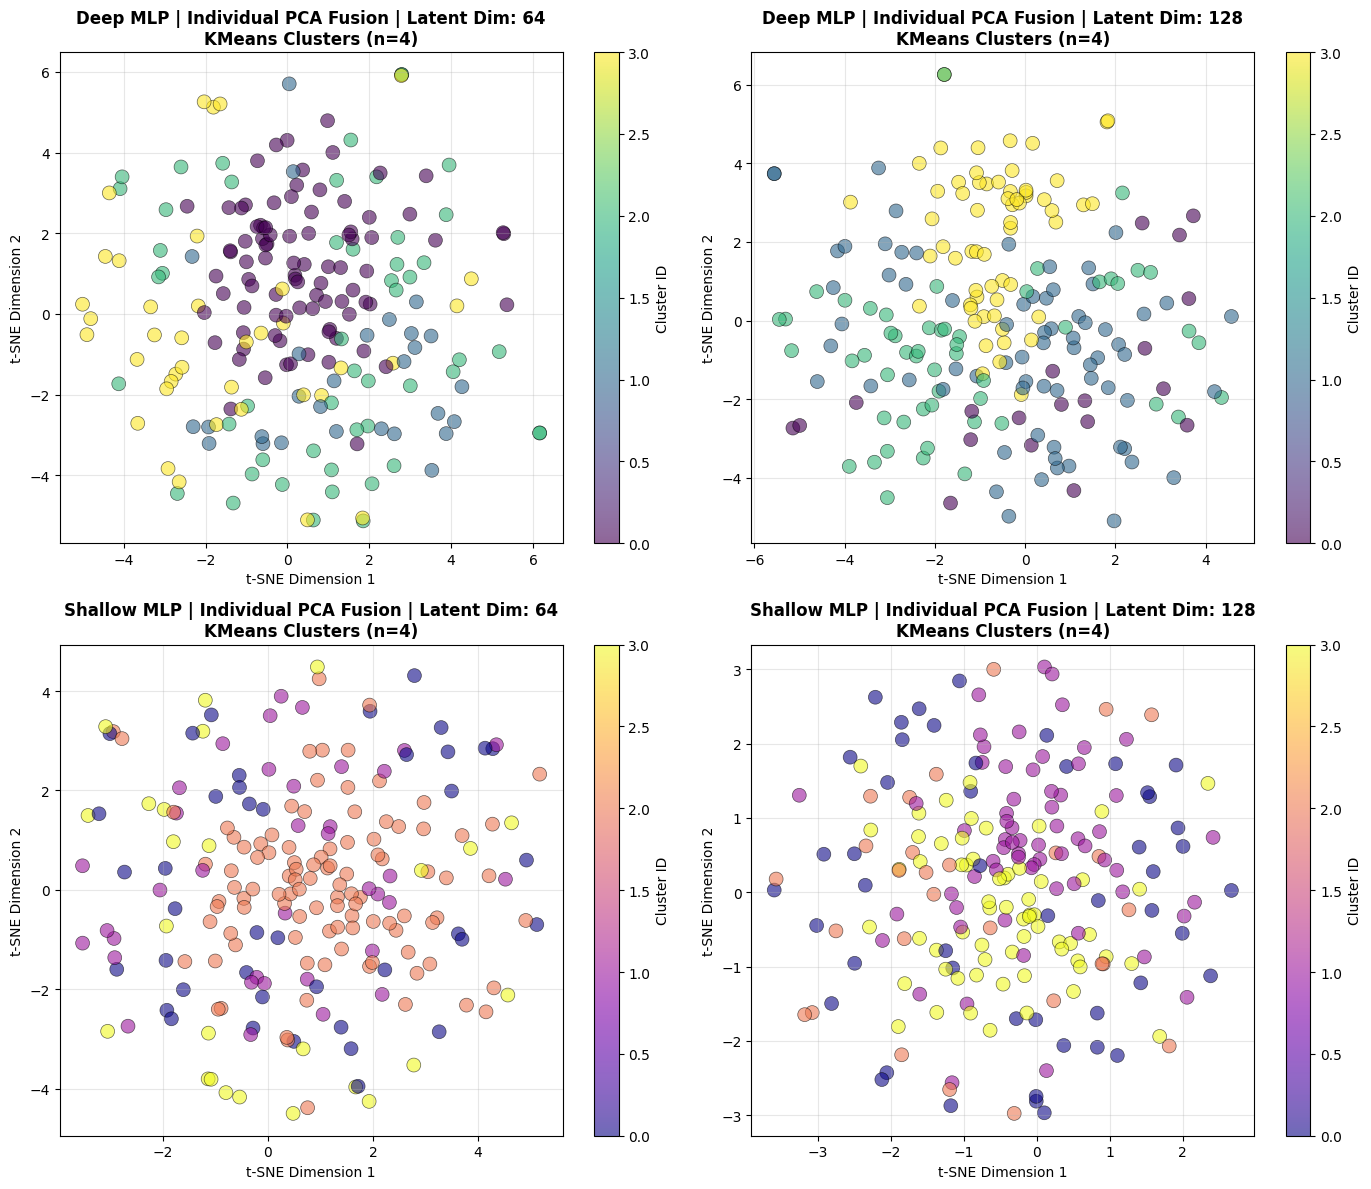


✅ Visualization completed for 2 latent dimensions!
   Top row: Deep MLP (Input → 512 → 256 → Latent)
   Bottom row: Shallow MLP (Input → Latent)
   Each plot shows KMeans clustering in 2D space (via t-SNE)


In [7]:

# VISUALIZATION: Deep and Shallow MLP Comparisons
print("=" * 100)
print("📊 MLP VISUALIZATION COMPARISON")
print("=" * 100)

n_latents = len(mlp_scores)
fig, axes = plt.subplots(2, n_latents, figsize=(7 * n_latents, 12))

# Handle single latent dimension case
if n_latents == 1:
    axes = axes.reshape(-1, 1)

y = labels.values.ravel()
n_clusters = len(np.unique(y))

for idx, latent_dim in enumerate(mlp_scores.keys()):
    # ============================================================================
    # DEEP MLP VISUALIZATION
    # ============================================================================
    # Get deep MLP embeddings
    embeddings_deep_np = mlp_embeddings[latent_dim]
    
    # Apply t-SNE for 2D visualization (if latent_dim > 2)
    if latent_dim > 2:
        tsne_deep = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_deep_np)-1))
        embeddings_deep_2d = tsne_deep.fit_transform(embeddings_deep_np)
    else:
        embeddings_deep_2d = embeddings_deep_np[:, :2]
    
    # Use KMeans for cluster assignment
    kmeans_deep = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_deep = kmeans_deep.fit_predict(embeddings_deep_np)
    
    # Plot deep MLP
    ax_deep = axes[0, idx]
    scatter_deep = ax_deep.scatter(embeddings_deep_2d[:, 0], embeddings_deep_2d[:, 1], 
                                  c=cluster_labels_deep, cmap='viridis', 
                                  s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax_deep.set_title(f'Deep MLP | Individual PCA Fusion | Latent Dim: {latent_dim}\nKMeans Clusters (n={n_clusters})', 
                     fontsize=12, fontweight='bold')
    ax_deep.set_xlabel('t-SNE Dimension 1' if latent_dim > 2 else 'Latent Dimension 1', fontsize=10)
    ax_deep.set_ylabel('t-SNE Dimension 2' if latent_dim > 2 else 'Latent Dimension 2', fontsize=10)
    ax_deep.grid(True, alpha=0.3)
    plt.colorbar(scatter_deep, ax=ax_deep, label='Cluster ID')
    
    # ============================================================================
    # SHALLOW MLP VISUALIZATION
    # ============================================================================
    # Get shallow MLP embeddings
    embeddings_shallow_np = shallow_mlp_embeddings[latent_dim]
    
    # Apply t-SNE for 2D visualization (if latent_dim > 2)
    if latent_dim > 2:
        tsne_shallow = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_shallow_np)-1))
        embeddings_shallow_2d = tsne_shallow.fit_transform(embeddings_shallow_np)
    else:
        embeddings_shallow_2d = embeddings_shallow_np[:, :2]
    
    # Use KMeans for cluster assignment
    kmeans_shallow = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_shallow = kmeans_shallow.fit_predict(embeddings_shallow_np)
    
    # Plot shallow MLP
    ax_shallow = axes[1, idx]
    scatter_shallow = ax_shallow.scatter(embeddings_shallow_2d[:, 0], embeddings_shallow_2d[:, 1], 
                                       c=cluster_labels_shallow, cmap='plasma', 
                                       s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax_shallow.set_title(f'Shallow MLP | Individual PCA Fusion | Latent Dim: {latent_dim}\nKMeans Clusters (n={n_clusters})', 
                        fontsize=12, fontweight='bold')
    ax_shallow.set_xlabel('t-SNE Dimension 1' if latent_dim > 2 else 'Latent Dimension 1', fontsize=10)
    ax_shallow.set_ylabel('t-SNE Dimension 2' if latent_dim > 2 else 'Latent Dimension 2', fontsize=10)
    ax_shallow.grid(True, alpha=0.3)
    plt.colorbar(scatter_shallow, ax=ax_shallow, label='Cluster ID')

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization completed for {n_latents} latent dimensions!")
print(f"   Top row: Deep MLP (Input → 512 → 256 → Latent)")
print(f"   Bottom row: Shallow MLP (Input → Latent)")
print(f"   Each plot shows KMeans clustering in 2D space (via t-SNE)")

In [8]:
# Display Evaluation Results in Tables
print("=" * 100)
print("📊 DEEP MLP PIPELINE EVALUATION RESULTS")
print("=" * 100)

# ============================================================================
# TABLE 1: DEEP MLP - ML MODEL PERFORMANCE METRICS
# ============================================================================
print("\n" + "=" * 100)
print("TABLE 1: DEEP MLP - MACHINE LEARNING MODEL PERFORMANCE")
print("=" * 100)

# Collect all ML model results for deep MLP
ml_results_table_deep = []

for latent_dim, results in mlp_scores.items():
    for model_name, metrics in results['ml_models'].items():
        row = {
            'Latent Dim': latent_dim,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'F1-Macro': metrics['f1_macro'],
            'F1-Micro': metrics['f1_micro'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'AUC': metrics['auc'] if metrics['auc'] is not None else np.nan,
            'C-Index': metrics['c_index'] if metrics['c_index'] is not None else np.nan,
            'CV-Mean': metrics['cv_mean'],
            'CV-Std': metrics['cv_std']
        }
        ml_results_table_deep.append(row)

# Create DataFrame
ml_df_deep = pd.DataFrame(ml_results_table_deep)

# Display full table with proper formatting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("\n📋 Deep MLP Complete ML Model Performance Table:")
print("-" * 100)
print(ml_df_deep.to_string(index=False))

# ============================================================================
# TABLE 2: DEEP MLP - STABILITY & CLUSTERING METRICS
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 2: DEEP MLP - STABILITY & CLUSTERING METRICS")
print("=" * 100)

# Collect stability metrics for deep MLP
stability_table_deep = []

for latent_dim, results in mlp_scores.items():
    row = {
        'Latent Dim': latent_dim,
        'ARI': results['ari'],
        'NMI': results['nmi'],
        'Silhouette': results['silhouette'],
        'Calinski-Harabasz': results['calinski_harabasz'],
        'Davies-Bouldin': results['davies_bouldin'],
        'Contrastive Loss': results['contrastive_loss'],
        'Embedding Shape': f"{results['embeddings_shape'][0]}x{results['embeddings_shape'][1]}"
    }
    stability_table_deep.append(row)

# Create DataFrame
stability_df_deep = pd.DataFrame(stability_table_deep)

print("\n📋 Deep MLP Complete Stability & Clustering Metrics Table:")
print("-" * 100)
print(stability_df_deep.to_string(index=False))

📊 DEEP MLP PIPELINE EVALUATION RESULTS

TABLE 1: DEEP MLP - MACHINE LEARNING MODEL PERFORMANCE

📋 Deep MLP Complete ML Model Performance Table:
----------------------------------------------------------------------------------------------------
 Latent Dim              Model  Accuracy  F1-Macro  F1-Micro  Precision  Recall    AUC  C-Index  CV-Mean  CV-Std
         64       RandomForest    0.5122    0.2363    0.5122     0.2534  0.2955 0.6332   0.5802   0.5122  0.0556
         64   GradientBoosting    0.4878    0.2945    0.4878     0.2919  0.3144 0.6142   0.4974   0.4293  0.0331
         64 LogisticRegression    0.5366    0.3287    0.5366     0.3500  0.3503 0.6147   0.5520   0.5024  0.0628
         64            SVM_RBF    0.5122    0.2381    0.5122     0.2917  0.2955 0.6500   0.5044   0.5317  0.0473
         64                KNN    0.4634    0.3249    0.4634     0.3750  0.3395 0.5349   0.5097   0.4098  0.0643
         64         NaiveBayes    0.3902    0.2355    0.3902     0.2292  0.25

In [9]:
# Display Shallow MLP Results in Separate Tables
print("=" * 100)
print("📊 SHALLOW MLP PIPELINE EVALUATION RESULTS")
print("=" * 100)

# ============================================================================
# TABLE 3: SHALLOW MLP - ML MODEL PERFORMANCE METRICS
# ============================================================================
print("\n" + "=" * 100)
print("TABLE 3: SHALLOW MLP - MACHINE LEARNING MODEL PERFORMANCE")
print("=" * 100)

# Collect all ML model results for shallow MLP
ml_results_table_shallow = []

for latent_dim, results in shallow_mlp_scores.items():
    for model_name, metrics in results['ml_models'].items():
        row = {
            'Latent Dim': latent_dim,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'F1-Macro': metrics['f1_macro'],
            'F1-Micro': metrics['f1_micro'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'AUC': metrics['auc'] if metrics['auc'] is not None else np.nan,
            'C-Index': metrics['c_index'] if metrics['c_index'] is not None else np.nan,
            'CV-Mean': metrics['cv_mean'],
            'CV-Std': metrics['cv_std']
        }
        ml_results_table_shallow.append(row)

# Create DataFrame
ml_df_shallow = pd.DataFrame(ml_results_table_shallow)

print("\n📋 Shallow MLP Complete ML Model Performance Table:")
print("-" * 100)
print(ml_df_shallow.to_string(index=False))

# ============================================================================
# TABLE 4: SHALLOW MLP - STABILITY & CLUSTERING METRICS
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 4: SHALLOW MLP - STABILITY & CLUSTERING METRICS")
print("=" * 100)

# Collect stability metrics for shallow MLP
stability_table_shallow = []

for latent_dim, results in shallow_mlp_scores.items():
    row = {
        'Latent Dim': latent_dim,
        'ARI': results['ari'],
        'NMI': results['nmi'],
        'Silhouette': results['silhouette'],
        'Calinski-Harabasz': results['calinski_harabasz'],
        'Davies-Bouldin': results['davies_bouldin'],
        'Contrastive Loss': results['contrastive_loss'],
        'Embedding Shape': f"{results['embeddings_shape'][0]}x{results['embeddings_shape'][1]}"
    }
    stability_table_shallow.append(row)

# Create DataFrame
stability_df_shallow = pd.DataFrame(stability_table_shallow)

print("\n📋 Shallow MLP Complete Stability & Clustering Metrics Table:")
print("-" * 100)
print(stability_df_shallow.to_string(index=False))

# ============================================================================
# COMPARISON SUMMARY: DEEP vs SHALLOW MLP
# ============================================================================
print("\n\n" + "=" * 100)
print("📊 ARCHITECTURE COMPARISON SUMMARY")
print("=" * 100)

print("\n🏗️  Architecture Details:")
print("   Deep MLP:    Input → 512 → 256 → Latent (2 hidden layers)")
print("   Shallow MLP: Input → Latent (0 hidden layers)")

print("\n📈 Performance Summary by Latent Dimension:")
print("-" * 100)

for latent_dim in mlp_scores.keys():
    print(f"\n📊 Latent Dimension: {latent_dim}")
    print("-" * 50)
    
    # Get best performing model for each architecture
    deep_results = mlp_scores[latent_dim]['ml_models']
    shallow_results = shallow_mlp_scores[latent_dim]['ml_models']
    
    # Find best accuracy for each
    deep_best_acc = max([metrics['accuracy'] for metrics in deep_results.values()])
    shallow_best_acc = max([metrics['accuracy'] for metrics in shallow_results.values()])
    
    deep_best_f1 = max([metrics['f1_macro'] for metrics in deep_results.values()])
    shallow_best_f1 = max([metrics['f1_macro'] for metrics in shallow_results.values()])
    
    print(f"   Deep MLP    - Best Accuracy: {deep_best_acc:.4f} | Best F1-Macro: {deep_best_f1:.4f}")
    print(f"   Shallow MLP - Best Accuracy: {shallow_best_acc:.4f} | Best F1-Macro: {shallow_best_f1:.4f}")
    
    # Clustering comparison
    print(f"   Deep MLP    - ARI: {mlp_scores[latent_dim]['ari']:.4f} | Silhouette: {mlp_scores[latent_dim]['silhouette']:.4f}")
    print(f"   Shallow MLP - ARI: {shallow_mlp_scores[latent_dim]['ari']:.4f} | Silhouette: {shallow_mlp_scores[latent_dim]['silhouette']:.4f}")
    
    # Contrastive loss comparison
    print(f"   Deep MLP    - Contrastive Loss: {mlp_scores[latent_dim]['contrastive_loss']:.6f}")
    print(f"   Shallow MLP - Contrastive Loss: {shallow_mlp_scores[latent_dim]['contrastive_loss']:.6f}")

print(f"\n{'='*100}")
print(f"✅ COMPARATIVE ANALYSIS COMPLETED!")
print(f"{'='*100}")

📊 SHALLOW MLP PIPELINE EVALUATION RESULTS

TABLE 3: SHALLOW MLP - MACHINE LEARNING MODEL PERFORMANCE

📋 Shallow MLP Complete ML Model Performance Table:
----------------------------------------------------------------------------------------------------
 Latent Dim              Model  Accuracy  F1-Macro  F1-Micro  Precision  Recall    AUC  C-Index  CV-Mean  CV-Std
         64       RandomForest    0.4390    0.1579    0.4390     0.1184  0.2368 0.6177   0.6949   0.5024  0.0396
         64   GradientBoosting    0.3415    0.1648    0.3415     0.1537  0.1938 0.5048   0.5732   0.4488  0.0331
         64 LogisticRegression    0.4878    0.3230    0.4878     0.3167  0.3500 0.6059   0.5591   0.4878  0.0267
         64            SVM_RBF    0.5366    0.2886    0.5366     0.3250  0.3278 0.6060   0.6737   0.5317  0.0585
         64                KNN    0.4634    0.2848    0.4634     0.2597  0.3457 0.6353   0.5529   0.4244  0.0628
         64         NaiveBayes    0.3415    0.2396    0.3415     0.2

📈 AUC-ROC CURVES FOR DEEP AND SHALLOW MLPS


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

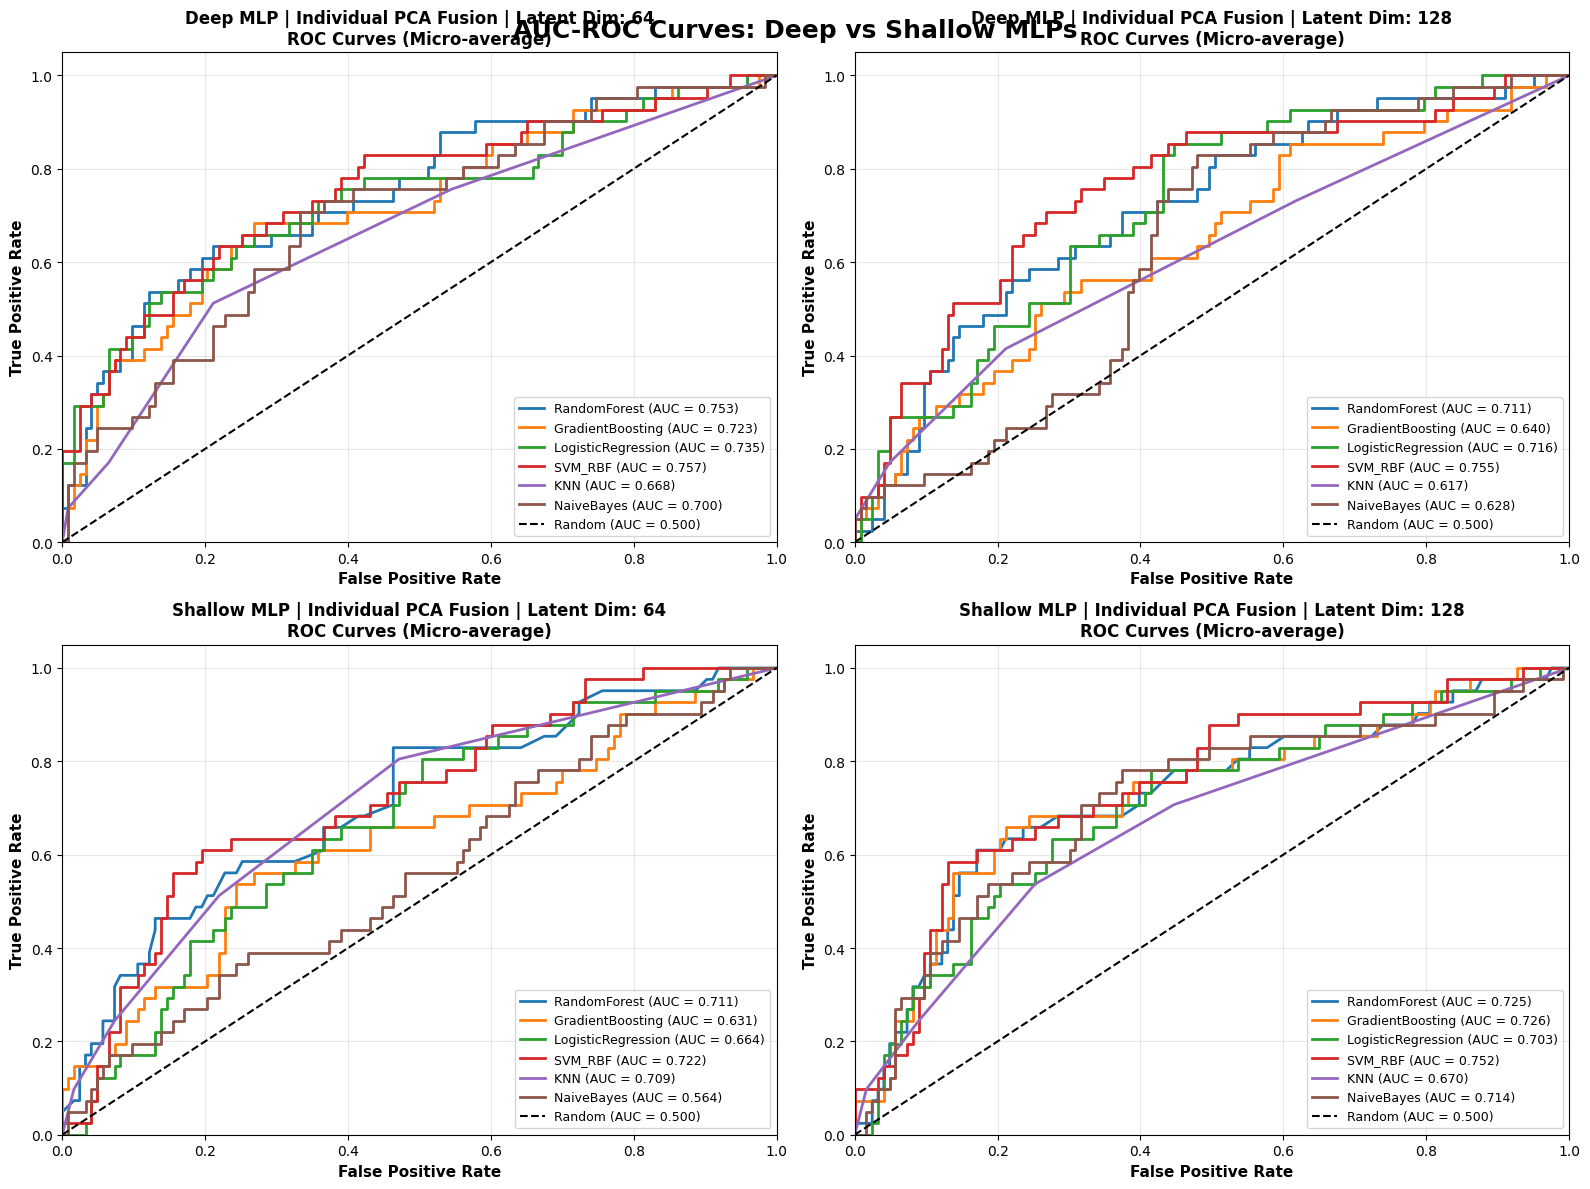


✅ ROC curves plotted for 2 latent dimensions!
   Top row: Deep MLP (Input → 512 → 256 → Latent)
   Bottom row: Shallow MLP (Input → Latent)
   Each subplot shows all 6 models for comparison
   Multiclass (micro-average) ROC curves

📊 AUC SUMMARY TABLES

📋 Deep MLP - AUC Scores by Configuration and Model:
----------------------------------------------------------------------------------------------------
 Latent Dim              Model    AUC
         64       RandomForest 0.6332
         64   GradientBoosting 0.6142
         64 LogisticRegression 0.6147
         64            SVM_RBF 0.6500
         64                KNN 0.5349
         64         NaiveBayes 0.5860
        128       RandomForest 0.5352
        128   GradientBoosting 0.4869
        128 LogisticRegression 0.6049
        128            SVM_RBF 0.6028
        128                KNN 0.5390
        128         NaiveBayes 0.5060

📋 Shallow MLP - AUC Scores by Configuration and Model:
------------------------------------------

In [10]:
# Plot AUC-ROC Curves for Deep and Shallow MLPs
print("=" * 100)
print("📈 AUC-ROC CURVES FOR DEEP AND SHALLOW MLPS")
print("=" * 100)

from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Get latent dimensions
latent_dims = list(mlp_scores.keys())
n_latents = len(latent_dims)

# Create subplots: 2 rows (Deep, Shallow) x n_latents columns
fig, axes = plt.subplots(2, n_latents, figsize=(8 * n_latents, 12))

# Handle single latent dimension case
if n_latents == 1:
    axes = axes.reshape(-1, 1)

# Get labels and classes
y = labels.values.ravel()
classes = np.unique(y)
n_classes = len(classes)

for idx, latent_dim in enumerate(latent_dims):
    
    # ============================================================================
    # DEEP MLP ROC CURVES
    # ============================================================================
    ax_deep = axes[0, idx]
    deep_results = mlp_scores[latent_dim]
    embeddings_deep_np = mlp_embeddings[latent_dim]
    
    # Store model colors for consistency
    model_colors = {}
    color_iter = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    
    for model_name in deep_results['ml_models'].keys():
        model_colors[model_name] = next(color_iter)
    
    # Train each model and plot ROC curve for deep autoencoder
    for model_name, metrics in deep_results['ml_models'].items():
        # Define model
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
        elif model_name == 'SVM_RBF':
            model = SVC(kernel='rbf', random_state=42, probability=True)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=4)
        elif model_name == 'NaiveBayes':
            model = GaussianNB()
        
        # Split data for proper evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings_deep_np, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train and predict
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        
        # Compute ROC curve
        if n_classes == 2:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            ax_deep.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                        label=f'{model_name} (AUC = {roc_auc:.3f})')
        else:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)
            ax_deep.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                        label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line for deep AE
    ax_deep.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (AUC = 0.500)')
    
    # Formatting for deep AE
    ax_deep.set_xlim([0.0, 1.0])
    ax_deep.set_ylim([0.0, 1.05])
    ax_deep.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax_deep.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax_deep.set_title(f'Deep MLP | Individual PCA Fusion | Latent Dim: {latent_dim}\nROC Curves ({"Binary" if n_classes == 2 else "Micro-average"})', 
                     fontsize=12, fontweight='bold')
    ax_deep.legend(loc="lower right", fontsize=9)
    ax_deep.grid(True, alpha=0.3)
    
    # ============================================================================
    # SHALLOW MLP ROC CURVES
    # ============================================================================
    ax_shallow = axes[1, idx]
    shallow_results = shallow_mlp_scores[latent_dim]
    embeddings_shallow_np = shallow_mlp_embeddings[latent_dim]
    
    # Train each model and plot ROC curve for shallow autoencoder
    for model_name, metrics in shallow_results['ml_models'].items():
        # Define model (same as above)
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
        elif model_name == 'SVM_RBF':
            model = SVC(kernel='rbf', random_state=42, probability=True)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=4)
        elif model_name == 'NaiveBayes':
            model = GaussianNB()
        
        # Split data for proper evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings_shallow_np, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train and predict
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        
        # Compute ROC curve
        if n_classes == 2:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            ax_shallow.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                           label=f'{model_name} (AUC = {roc_auc:.3f})')
        else:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)
            ax_shallow.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                           label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line for shallow AE
    ax_shallow.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (AUC = 0.500)')
    
    # Formatting for shallow AE
    ax_shallow.set_xlim([0.0, 1.0])
    ax_shallow.set_ylim([0.0, 1.05])
    ax_shallow.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax_shallow.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax_shallow.set_title(f'Shallow MLP | Individual PCA Fusion | Latent Dim: {latent_dim}\nROC Curves ({"Binary" if n_classes == 2 else "Micro-average"})', 
                        fontsize=12, fontweight='bold')
    ax_shallow.legend(loc="lower right", fontsize=9)
    ax_shallow.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('AUC-ROC Curves: Deep vs Shallow MLPs', 
            fontsize=18, fontweight='bold', y=0.98)
plt.show()

print(f"\n✅ ROC curves plotted for {n_latents} latent dimensions!")
print(f"   Top row: Deep MLP (Input → 512 → 256 → Latent)")
print(f"   Bottom row: Shallow MLP (Input → Latent)")
print(f"   Each subplot shows all 6 models for comparison")
print(f"   {"Binary classification" if n_classes == 2 else "Multiclass (micro-average) ROC curves"}")

# ============================================================================
# Summary Tables: AUC Scores for Deep and Shallow MLPs
# ============================================================================
print("\n" + "=" * 100)
print("📊 AUC SUMMARY TABLES")
print("=" * 100)

# Deep MLP AUC Summary
auc_summary_deep = []
for latent_dim in latent_dims:
    results = mlp_scores[latent_dim]
    
    for model_name, metrics in results['ml_models'].items():
        auc_val = metrics['auc'] if metrics['auc'] is not None else np.nan
        auc_summary_deep.append({
            'Latent Dim': latent_dim,
            'Model': model_name,
            'AUC': auc_val
        })

auc_df_deep = pd.DataFrame(auc_summary_deep)
print("\n📋 Deep MLP - AUC Scores by Configuration and Model:")
print("-" * 100)
print(auc_df_deep.to_string(index=False))

# Shallow MLP AUC Summary
auc_summary_shallow = []
for latent_dim in latent_dims:
    results = shallow_mlp_scores[latent_dim]
    
    for model_name, metrics in results['ml_models'].items():
        auc_val = metrics['auc'] if metrics['auc'] is not None else np.nan
        auc_summary_shallow.append({
            'Latent Dim': latent_dim,
            'Model': model_name,
            'AUC': auc_val
        })

auc_df_shallow = pd.DataFrame(auc_summary_shallow)
print("\n📋 Shallow MLP - AUC Scores by Configuration and Model:")
print("-" * 100)
print(auc_df_shallow.to_string(index=False))